# 🤖 SLEEP QUALITY PREDICTION - MODEL TRAINING & EVALUATION
---
**Project:** Predicting Sleep Efficiency from Fitbit Activity Data  
**Models:** Logistic Regression, Random Forest, XGBoost  
**Goal:** Build, evaluate, and compare models for deployment in Streamlit UI

---

## 📋 Table of Contents

1. **Setup & Data Loading** - Import libraries and load ML-ready dataset
2. **Data Preparation** - Train-test split, feature scaling, baseline metrics
3. **Logistic Regression** - Train, evaluate, interpret coefficients
4. **Random Forest** - Train, tune, feature importance
5. **XGBoost** - Train, tune, SHAP values
6. **Model Comparison** - Performance metrics, ROC curves, confusion matrices
7. **Model Explainability** - Feature importance analysis for all models
8. **Save Best Model** - Export for Streamlit deployment
9. **Recommendations** - Actionable insights from model findings

---
## 1️⃣ SETUP & DATA LOADING

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn - Model Selection & Metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Sklearn - Preprocessing
from sklearn.preprocessing import StandardScaler

# Sklearn - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost
try:
    import xgboost as xgb
    print("✅ XGBoost imported successfully")
except ImportError:
    print("⚠️  XGBoost not installed. Run: pip install xgboost")
    xgb = None

# SHAP for explainability
try:
    import shap
    print("✅ SHAP imported successfully")
except ImportError:
    print("⚠️  SHAP not installed. Run: pip install shap")
    shap = None

# Model persistence
import joblib
import pickle

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\n" + "="*60)
print("✅ ALL LIBRARIES LOADED SUCCESSFULLY")
print("="*60)

✅ XGBoost imported successfully
⚠️  SHAP not installed. Run: pip install shap

✅ ALL LIBRARIES LOADED SUCCESSFULLY


In [2]:
# Load the ML-ready dataset
print("="*60)
print("LOADING ML-READY DATASET")
print("="*60)

df = pd.read_csv('ml_ready_sleep_prediction_FINAL.csv')

print(f"\n✅ Data loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Unique users: {df['Id'].nunique()}")
print(f"Date range: {df['ActivityDate'].min()} to {df['ActivityDate'].max()}")

print("\nFirst 5 rows:")
display(df.head())

print("\nColumn data types:")
display(df.dtypes)

print("\nTarget variable distribution:")
print(df['GoodSleep'].value_counts())
print(f"\nGood Sleep: {df['GoodSleep'].mean()*100:.1f}%")
print(f"Poor Sleep: {(1-df['GoodSleep'].mean())*100:.1f}%")

LOADING ML-READY DATASET

✅ Data loaded successfully!

Dataset shape: (643, 12)
Unique users: 24
Date range: 2016-03-12 to 2016-05-12

First 5 rows:


,Id,ActivityDate,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,TotalCalories_hourly,TotalSteps_hourly,ActiveRatio,IsWeekend,GoodSleep,SleepEfficiency
0,1503960366,2016-03-25,33,12,205,804,1819.0000,11004.0000,0.2372,0,1,90.9326
1,1503960366,2016-03-26,89,17,274,588,2154.0000,17609.0000,0.3926,1,1,92.5847
2,1503960366,2016-03-27,56,5,268,605,1943.0000,12736.0000,0.3522,1,1,95.4545
3,1503960366,2016-03-28,39,20,224,1080,1931.0000,13231.0000,0.2076,0,1,94.8052
4,1503960366,2016-03-29,28,28,243,763,1887.0000,12041.0000,0.2815,0,1,92.3280



Column data types:


Id                        int64
ActivityDate             object
VeryActiveMinutes         int64
FairlyActiveMinutes       int64
LightlyActiveMinutes      int64
SedentaryMinutes          int64
TotalCalories_hourly    float64
TotalSteps_hourly       float64
ActiveRatio             float64
IsWeekend                 int64
GoodSleep                 int64
SleepEfficiency         float64
dtype: object


Target variable distribution:
GoodSleep
1    582
0     61
Name: count, dtype: int64

Good Sleep: 90.5%
Poor Sleep: 9.5%


---
## 2️⃣ DATA PREPARATION
Split data into train/test sets with stratification to maintain class balance

In [3]:
print("="*60)
print("PREPARING DATA FOR MODELING")
print("="*60)

# Define features (exclude metadata and target)
exclude_cols = ['Id', 'ActivityDate', 'GoodSleep', 'SleepEfficiency']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nFeatures selected for modeling ({len(feature_cols)}):")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {feat}")

# Prepare X and y
X = df[feature_cols]
y = df['GoodSleep']

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

# Check for missing values
missing = X.isnull().sum().sum()
if missing > 0:
    print(f"\n⚠️  Warning: {missing} missing values detected!")
else:
    print(f"\n✅ No missing values in features")

# Train-test split (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 80% train, 20% test
    random_state=42,
    stratify=y  # Maintain class balance in both sets
)

print("\n" + "="*60)
print("TRAIN-TEST SPLIT COMPLETE")
print("="*60)
print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nClass balance in training set:")
print(y_train.value_counts())
print(f"Good Sleep: {y_train.mean()*100:.1f}%")

print("\nClass balance in test set:")
print(y_test.value_counts())
print(f"Good Sleep: {y_test.mean()*100:.1f}%")

# Feature scaling for Logistic Regression
print("\n" + "="*60)
print("FEATURE SCALING (for Logistic Regression)")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("✅ Features scaled using StandardScaler")
print("   (Mean=0, Std=1 for all features)")
print("\nScaled features summary:")
display(X_train_scaled.describe())

PREPARING DATA FOR MODELING

Features selected for modeling (8):
   1. VeryActiveMinutes
   2. FairlyActiveMinutes
   3. LightlyActiveMinutes
   4. SedentaryMinutes
   5. TotalCalories_hourly
   6. TotalSteps_hourly
   7. ActiveRatio
   8. IsWeekend

X shape: (643, 8)
y shape: (643,)

✅ No missing values in features

TRAIN-TEST SPLIT COMPLETE

Training set: 514 samples (79.9%)
Test set: 129 samples (20.1%)

Class balance in training set:
GoodSleep
1    465
0     49
Name: count, dtype: int64
Good Sleep: 90.5%

Class balance in test set:
GoodSleep
1    117
0     12
Name: count, dtype: int64
Good Sleep: 90.7%

FEATURE SCALING (for Logistic Regression)
✅ Features scaled using StandardScaler
   (Mean=0, Std=1 for all features)

Scaled features summary:


,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,TotalCalories_hourly,TotalSteps_hourly,ActiveRatio,IsWeekend
count,514.0000,514.0000,514.0000,514.0000,514.0000,514.0000,514.0000,514.0000
mean,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000
std,1.0010,1.0010,1.0010,1.0010,1.0010,1.0010,1.0010,1.0010
min,-0.6859,-0.8101,-2.4208,-3.9180,-2.8878,-1.9992,-2.5437,-0.6058
25%,-0.6859,-0.8101,-0.6738,-0.4805,-0.6872,-0.7981,-0.5340,-0.6058
50%,-0.4524,-0.2963,-0.0538,-0.0222,-0.2338,0.0618,-0.0526,-0.6058
75%,0.3647,0.4044,0.6003,0.4308,0.6284,0.7026,0.5271,1.6506
max,5.4425,5.8695,3.4344,3.3460,4.0553,3.3807,7.2058,1.6506


In [4]:
# Baseline model - Always predict majority class
print("="*60)
print("BASELINE MODEL (for comparison)")
print("="*60)

# Most common class in training set
majority_class = y_train.mode()[0]
baseline_predictions = np.full(len(y_test), majority_class)

baseline_accuracy = accuracy_score(y_test, baseline_predictions)

print(f"\nStrategy: Always predict '{majority_class}' (majority class)")
print(f"Baseline Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print("\n⚠️  Our models must beat this baseline to be useful!")
print(f"    Target: >{baseline_accuracy*100:.0f}% accuracy")

BASELINE MODEL (for comparison)

Strategy: Always predict '1' (majority class)
Baseline Accuracy: 0.9070 (90.70%)

⚠️  Our models must beat this baseline to be useful!
    Target: >91% accuracy


---
## 3️⃣ LOGISTIC REGRESSION
Simple, fast, and highly interpretable model - perfect for understanding feature effects

In [5]:
print("="*60)
print("TRAINING LOGISTIC REGRESSION MODEL")
print("="*60)

# Train model
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance
)

lr_model.fit(X_train_scaled, y_train)

print("✅ Model training complete!\n")

# Make predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)
lr_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
print("="*60)
print("LOGISTIC REGRESSION - PERFORMANCE METRICS")
print("="*60)

# Training set performance
lr_train_acc = accuracy_score(y_train, lr_train_pred)
print(f"\nTraining Accuracy: {lr_train_acc:.4f} ({lr_train_acc*100:.2f}%)")

# Test set performance
lr_test_acc = accuracy_score(y_test, lr_test_pred)
lr_precision = precision_score(y_test, lr_test_pred)
lr_recall = recall_score(y_test, lr_test_pred)
lr_f1 = f1_score(y_test, lr_test_pred)
lr_auc = roc_auc_score(y_test, lr_test_proba)

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {lr_test_acc:.4f} ({lr_test_acc*100:.2f}%)")
print(f"  Precision: {lr_precision:.4f} ({lr_precision*100:.2f}%)")
print(f"  Recall:    {lr_recall:.4f} ({lr_recall*100:.2f}%)")
print(f"  F1-Score:  {lr_f1:.4f}")
print(f"  ROC-AUC:   {lr_auc:.4f}")

# Overfitting check
if lr_train_acc - lr_test_acc > 0.1:
    print(f"\n⚠️  Warning: Possible overfitting (train-test gap: {(lr_train_acc-lr_test_acc)*100:.1f}%)")
else:
    print(f"\n✅ No significant overfitting (train-test gap: {(lr_train_acc-lr_test_acc)*100:.1f}%)")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, lr_test_pred, target_names=['Poor Sleep', 'Good Sleep']))

# Confusion Matrix
lr_cm = confusion_matrix(y_test, lr_test_pred)
print("\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 Poor  Good")
print(f"Actual Poor:     {lr_cm[0,0]:4d}  {lr_cm[0,1]:4d}")
print(f"       Good:     {lr_cm[1,0]:4d}  {lr_cm[1,1]:4d}")

TRAINING LOGISTIC REGRESSION MODEL
✅ Model training complete!

LOGISTIC REGRESSION - PERFORMANCE METRICS

Training Accuracy: 0.8074 (80.74%)

Test Set Performance:
  Accuracy:  0.7287 (72.87%)
  Precision: 0.9767 (97.67%)
  Recall:    0.7179 (71.79%)
  F1-Score:  0.8276
  ROC-AUC:   0.8832

✅ No significant overfitting (train-test gap: 7.9%)

Detailed Classification Report:
              precision    recall  f1-score   support

  Poor Sleep       0.23      0.83      0.36        12
  Good Sleep       0.98      0.72      0.83       117

    accuracy                           0.73       129
   macro avg       0.60      0.78      0.60       129
weighted avg       0.91      0.73      0.78       129


Confusion Matrix:
                 Predicted
                 Poor  Good
Actual Poor:       10     2
       Good:       33    84


LOGISTIC REGRESSION - COEFFICIENT INTERPRETATION

Feature Coefficients (sorted by importance):
Positive = Increases Good Sleep probability
Negative = Decreases Good Sleep probability

  TotalCalories_hourly          : +1.4779  📈 POSITIVE
  VeryActiveMinutes             : +1.3558  📈 POSITIVE
  TotalSteps_hourly             : -1.0287  📉 NEGATIVE
  FairlyActiveMinutes           : -0.8525  📉 NEGATIVE
  SedentaryMinutes              : -0.5973  📉 NEGATIVE
  LightlyActiveMinutes          : +0.5609  📈 POSITIVE
  IsWeekend                     : -0.3586  📉 NEGATIVE
  ActiveRatio                   : +0.0114  📈 POSITIVE

Intercept: 1.2285


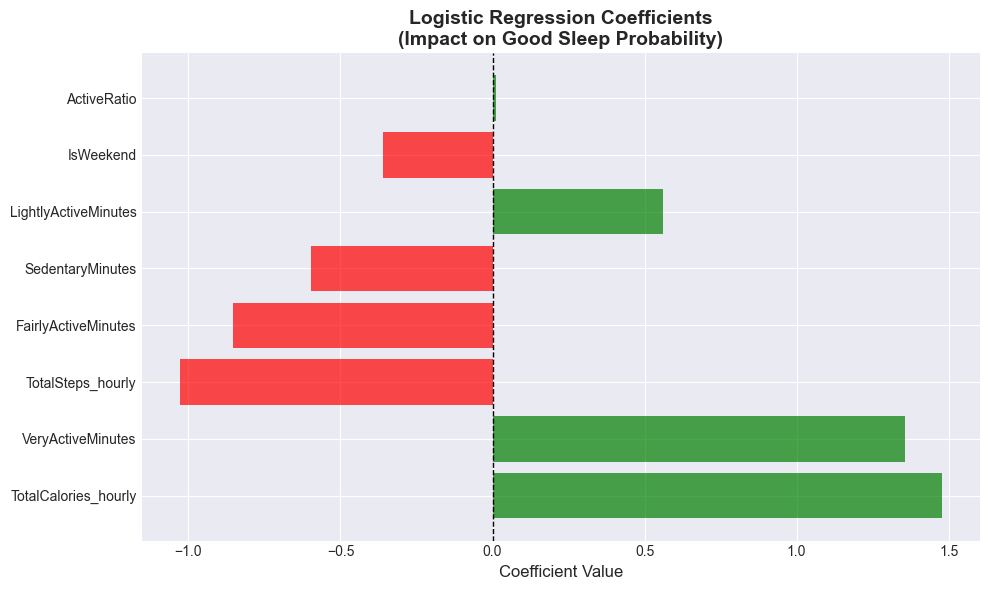


💡 INSIGHTS:
  Most important positive factor: TotalCalories_hourly (+1.4779)
  Most important negative factor: ActiveRatio (+0.0114)


In [6]:
# Extract and interpret coefficients
print("="*60)
print("LOGISTIC REGRESSION - COEFFICIENT INTERPRETATION")
print("="*60)

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Coefficients (sorted by importance):")
print("Positive = Increases Good Sleep probability")
print("Negative = Decreases Good Sleep probability\n")

for idx, row in coefficients.iterrows():
    direction = "📈 POSITIVE" if row['Coefficient'] > 0 else "📉 NEGATIVE"
    print(f"  {row['Feature']:30s}: {row['Coefficient']:+.4f}  {direction}")

print(f"\nIntercept: {lr_model.intercept_[0]:.4f}")

# Visualize coefficients
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in coefficients['Coefficient']]
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Logistic Regression Coefficients\n(Impact on Good Sleep Probability)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

print("\n💡 INSIGHTS:")
print(f"  Most important positive factor: {coefficients.iloc[0]['Feature']} ({coefficients.iloc[0]['Coefficient']:+.4f})")
print(f"  Most important negative factor: {coefficients.iloc[-1]['Feature']} ({coefficients.iloc[-1]['Coefficient']:+.4f})")

---
## 4️⃣ RANDOM FOREST CLASSIFIER
Ensemble method that captures non-linear relationships and interactions

In [7]:
print("="*60)
print("TRAINING RANDOM FOREST MODEL")
print("="*60)

# Initial model with default parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1  # Use all CPU cores
)

rf_model.fit(X_train, y_train)  # No scaling needed for RF!

print("✅ Initial model training complete!\n")

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("="*60)
print("RANDOM FOREST - INITIAL PERFORMANCE")
print("="*60)

rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)
rf_precision = precision_score(y_test, rf_test_pred)
rf_recall = recall_score(y_test, rf_test_pred)
rf_f1 = f1_score(y_test, rf_test_pred)
rf_auc = roc_auc_score(y_test, rf_test_proba)

print(f"\nTraining Accuracy: {rf_train_acc:.4f} ({rf_train_acc*100:.2f}%)")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {rf_test_acc:.4f} ({rf_test_acc*100:.2f}%)")
print(f"  Precision: {rf_precision:.4f} ({rf_precision*100:.2f}%)")
print(f"  Recall:    {rf_recall:.4f} ({rf_recall*100:.2f}%)")
print(f"  F1-Score:  {rf_f1:.4f}")
print(f"  ROC-AUC:   {rf_auc:.4f}")

if rf_train_acc - rf_test_acc > 0.15:
    print(f"\n⚠️  Warning: Overfitting detected (train-test gap: {(rf_train_acc-rf_test_acc)*100:.1f}%)")
    print("    Will tune hyperparameters to reduce overfitting...")
else:
    print(f"\n✅ Acceptable generalization (train-test gap: {(rf_train_acc-rf_test_acc)*100:.1f}%)")

print("\nClassification Report:")
print(classification_report(y_test, rf_test_pred, target_names=['Poor Sleep', 'Good Sleep']))

TRAINING RANDOM FOREST MODEL
✅ Initial model training complete!

RANDOM FOREST - INITIAL PERFORMANCE

Training Accuracy: 1.0000 (100.00%)

Test Set Performance:
  Accuracy:  0.9457 (94.57%)
  Precision: 0.9435 (94.35%)
  Recall:    1.0000 (100.00%)
  F1-Score:  0.9710
  ROC-AUC:   0.8992

✅ Acceptable generalization (train-test gap: 5.4%)

Classification Report:
              precision    recall  f1-score   support

  Poor Sleep       1.00      0.42      0.59        12
  Good Sleep       0.94      1.00      0.97       117

    accuracy                           0.95       129
   macro avg       0.97      0.71      0.78       129
weighted avg       0.95      0.95      0.94       129

RANDOM FOREST - INITIAL PERFORMANCE

Training Accuracy: 1.0000 (100.00%)

Test Set Performance:
  Accuracy:  0.9457 (94.57%)
  Precision: 0.9435 (94.35%)
  Recall:    1.0000 (100.00%)
  F1-Score:  0.9710
  ROC-AUC:   0.8992

✅ Acceptable generalization (train-test gap: 5.4%)

Classification Report:
        

In [8]:
# Hyperparameter tuning with GridSearchCV
print("="*60)
print("RANDOM FOREST - HYPERPARAMETER TUNING")
print("="*60)

print("\n🔍 Testing different hyperparameters...")
print("This may take 1-2 minutes...\n")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("\n✅ Hyperparameter tuning complete!\n")

# Best parameters
print("Best hyperparameters found:")
for param, value in rf_grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {rf_grid.best_score_:.4f}")

# Use best model
rf_best_model = rf_grid.best_estimator_

# Re-evaluate with tuned model
rf_tuned_train_pred = rf_best_model.predict(X_train)
rf_tuned_test_pred = rf_best_model.predict(X_test)
rf_tuned_test_proba = rf_best_model.predict_proba(X_test)[:, 1]

rf_tuned_train_acc = accuracy_score(y_train, rf_tuned_train_pred)
rf_tuned_test_acc = accuracy_score(y_test, rf_tuned_test_pred)
rf_tuned_precision = precision_score(y_test, rf_tuned_test_pred)
rf_tuned_recall = recall_score(y_test, rf_tuned_test_pred)
rf_tuned_f1 = f1_score(y_test, rf_tuned_test_pred)
rf_tuned_auc = roc_auc_score(y_test, rf_tuned_test_proba)

print("\n" + "="*60)
print("RANDOM FOREST - TUNED PERFORMANCE")
print("="*60)

print(f"\nTraining Accuracy: {rf_tuned_train_acc:.4f} ({rf_tuned_train_acc*100:.2f}%)")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {rf_tuned_test_acc:.4f} ({rf_tuned_test_acc*100:.2f}%)")
print(f"  Precision: {rf_tuned_precision:.4f} ({rf_tuned_precision*100:.2f}%)")
print(f"  Recall:    {rf_tuned_recall:.4f} ({rf_tuned_recall*100:.2f}%)")
print(f"  F1-Score:  {rf_tuned_f1:.4f}")
print(f"  ROC-AUC:   {rf_tuned_auc:.4f}")

# Compare with initial model
improvement = rf_tuned_test_acc - rf_test_acc
if improvement > 0:
    print(f"\n📈 Improvement: +{improvement*100:.2f}% accuracy from hyperparameter tuning")
else:
    print(f"\n📊 Performance similar to initial model")

# Update to use best model
rf_model = rf_best_model
rf_test_pred = rf_tuned_test_pred
rf_test_proba = rf_tuned_test_proba

RANDOM FOREST - HYPERPARAMETER TUNING

🔍 Testing different hyperparameters...
This may take 1-2 minutes...

Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Hyperparameter tuning complete!

Best hyperparameters found:
  max_depth: 10
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 100

Best cross-validation score: 0.9572

RANDOM FOREST - TUNED PERFORMANCE

Training Accuracy: 1.0000 (100.00%)

Test Set Performance:
  Accuracy:  0.9457 (94.57%)
  Precision: 0.9435 (94.35%)
  Recall:    1.0000 (100.00%)
  F1-Score:  0.9710
  ROC-AUC:   0.8675

📊 Performance similar to initial model

✅ Hyperparameter tuning complete!

Best hyperparameters found:
  max_depth: 10
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 100

Best cross-validation score: 0.9572

RANDOM FOREST - TUNED PERFORMANCE

Training Accuracy: 1.0000 (100.00%)

Test Set Performance:
  Accuracy:  0.9457 (94.57%)
  Precision: 0.9435 (94.35%)
  Recall:    1.0000 (100.00%)
  F1-Score:  0.9710

RANDOM FOREST - FEATURE IMPORTANCE

Features ranked by importance:
(Higher = More important for predictions)

  TotalCalories_hourly          : 0.3496  █████████████████
  FairlyActiveMinutes           : 0.1642  ████████
  SedentaryMinutes              : 0.1203  ██████
  LightlyActiveMinutes          : 0.1062  █████
  TotalSteps_hourly             : 0.0941  ████
  ActiveRatio                   : 0.0884  ████
  VeryActiveMinutes             : 0.0624  ███
  IsWeekend                     : 0.0148  

Features ranked by importance:
(Higher = More important for predictions)

  TotalCalories_hourly          : 0.3496  █████████████████
  FairlyActiveMinutes           : 0.1642  ████████
  SedentaryMinutes              : 0.1203  ██████
  LightlyActiveMinutes          : 0.1062  █████
  TotalSteps_hourly             : 0.0941  ████
  ActiveRatio                   : 0.0884  ████
  VeryActiveMinutes             : 0.0624  ███
  IsWeekend                     : 0.0148  


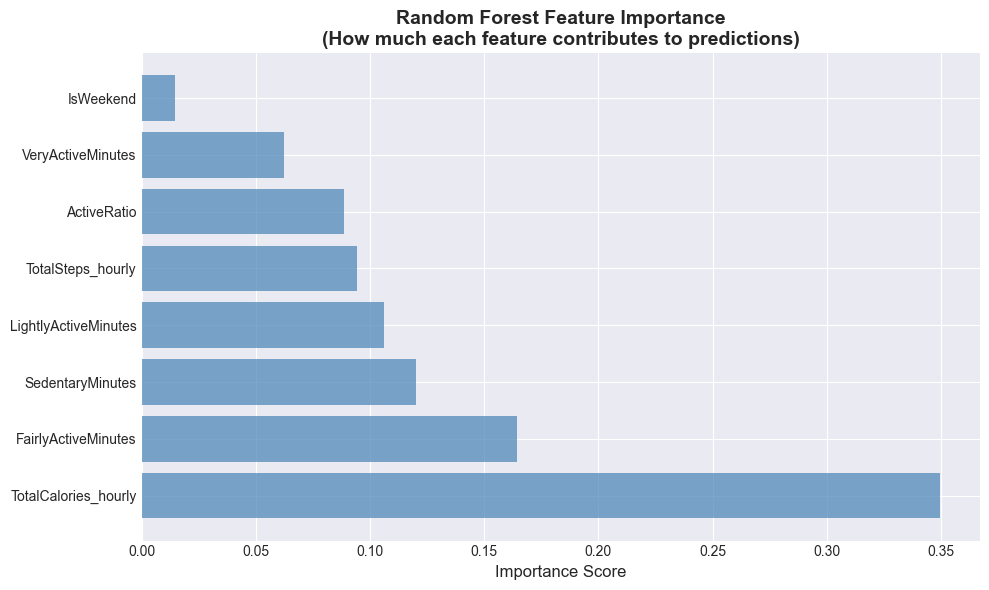


💡 KEY INSIGHTS:
  Most important feature: TotalCalories_hourly (0.3496)
  Top 3 features account for: 63.4% of importance


In [9]:
# Feature importance analysis
print("="*60)
print("RANDOM FOREST - FEATURE IMPORTANCE")
print("="*60)

# Get feature importance
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeatures ranked by importance:")
print("(Higher = More important for predictions)\n")

for idx, row in rf_importance.iterrows():
    bar_length = int(row['Importance'] * 50)
    bar = '█' * bar_length
    print(f"  {row['Feature']:30s}: {row['Importance']:.4f}  {bar}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_importance['Feature'], rf_importance['Importance'], color='steelblue', alpha=0.7)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Random Forest Feature Importance\n(How much each feature contributes to predictions)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHTS:")
print(f"  Most important feature: {rf_importance.iloc[0]['Feature']} ({rf_importance.iloc[0]['Importance']:.4f})")
print(f"  Top 3 features account for: {rf_importance.head(3)['Importance'].sum()*100:.1f}% of importance")

---
## 5️⃣ XGBOOST CLASSIFIER
Gradient boosting for maximum accuracy and advanced feature interactions

In [10]:
if xgb is None:
    print("⚠️  XGBoost not installed. Installing now...")
    import sys
    !{sys.executable} -m pip install xgboost
    import xgboost as xgb
    print("✅ XGBoost installed successfully!")

In [11]:
print("="*60)
print("TRAINING XGBOOST MODEL")
print("="*60)

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

# Initial model
xgb_model = xgb.XGBClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)

print("✅ Initial model training complete!\n")

# Make predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)
xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("="*60)
print("XGBOOST - INITIAL PERFORMANCE")
print("="*60)

xgb_train_acc = accuracy_score(y_train, xgb_train_pred)
xgb_test_acc = accuracy_score(y_test, xgb_test_pred)
xgb_precision = precision_score(y_test, xgb_test_pred)
xgb_recall = recall_score(y_test, xgb_test_pred)
xgb_f1 = f1_score(y_test, xgb_test_pred)
xgb_auc = roc_auc_score(y_test, xgb_test_proba)

print(f"\nTraining Accuracy: {xgb_train_acc:.4f} ({xgb_train_acc*100:.2f}%)")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {xgb_test_acc:.4f} ({xgb_test_acc*100:.2f}%)")
print(f"  Precision: {xgb_precision:.4f} ({xgb_precision*100:.2f}%)")
print(f"  Recall:    {xgb_recall:.4f} ({xgb_recall*100:.2f}%)")
print(f"  F1-Score:  {xgb_f1:.4f}")
print(f"  ROC-AUC:   {xgb_auc:.4f}")

if xgb_train_acc - xgb_test_acc > 0.15:
    print(f"\n⚠️  Warning: Overfitting detected (train-test gap: {(xgb_train_acc-xgb_test_acc)*100:.1f}%)")
else:
    print(f"\n✅ Good generalization (train-test gap: {(xgb_train_acc-xgb_test_acc)*100:.1f}%)")

print("\nClassification Report:")
print(classification_report(y_test, xgb_test_pred, target_names=['Poor Sleep', 'Good Sleep']))

TRAINING XGBOOST MODEL
✅ Initial model training complete!

XGBOOST - INITIAL PERFORMANCE

Training Accuracy: 0.9533 (95.33%)

Test Set Performance:
  Accuracy:  0.8605 (86.05%)
  Precision: 0.9459 (94.59%)
  Recall:    0.8974 (89.74%)
  F1-Score:  0.9211
  ROC-AUC:   0.8711

✅ Good generalization (train-test gap: 9.3%)

Classification Report:
              precision    recall  f1-score   support

  Poor Sleep       0.33      0.50      0.40        12
  Good Sleep       0.95      0.90      0.92       117

    accuracy                           0.86       129
   macro avg       0.64      0.70      0.66       129
weighted avg       0.89      0.86      0.87       129

✅ Initial model training complete!

XGBOOST - INITIAL PERFORMANCE

Training Accuracy: 0.9533 (95.33%)

Test Set Performance:
  Accuracy:  0.8605 (86.05%)
  Precision: 0.9459 (94.59%)
  Recall:    0.8974 (89.74%)
  F1-Score:  0.9211
  ROC-AUC:   0.8711

✅ Good generalization (train-test gap: 9.3%)

Classification Report:
      

In [12]:
# Hyperparameter tuning for XGBoost
print("="*60)
print("XGBOOST - HYPERPARAMETER TUNING")
print("="*60)

print("\n🔍 Testing different hyperparameters...")
print("This may take 2-3 minutes...\n")

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        use_label_encoder=False
    ),
    param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

print("\n✅ Hyperparameter tuning complete!\n")

print("Best hyperparameters found:")
for param, value in xgb_grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {xgb_grid.best_score_:.4f}")

# Use best model
xgb_best_model = xgb_grid.best_estimator_

# Re-evaluate
xgb_tuned_train_pred = xgb_best_model.predict(X_train)
xgb_tuned_test_pred = xgb_best_model.predict(X_test)
xgb_tuned_test_proba = xgb_best_model.predict_proba(X_test)[:, 1]

xgb_tuned_train_acc = accuracy_score(y_train, xgb_tuned_train_pred)
xgb_tuned_test_acc = accuracy_score(y_test, xgb_tuned_test_pred)
xgb_tuned_precision = precision_score(y_test, xgb_tuned_test_pred)
xgb_tuned_recall = recall_score(y_test, xgb_tuned_test_pred)
xgb_tuned_f1 = f1_score(y_test, xgb_tuned_test_pred)
xgb_tuned_auc = roc_auc_score(y_test, xgb_tuned_test_proba)

print("\n" + "="*60)
print("XGBOOST - TUNED PERFORMANCE")
print("="*60)

print(f"\nTraining Accuracy: {xgb_tuned_train_acc:.4f} ({xgb_tuned_train_acc*100:.2f}%)")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {xgb_tuned_test_acc:.4f} ({xgb_tuned_test_acc*100:.2f}%)")
print(f"  Precision: {xgb_tuned_precision:.4f} ({xgb_tuned_precision*100:.2f}%)")
print(f"  Recall:    {xgb_tuned_recall:.4f} ({xgb_tuned_recall*100:.2f}%)")
print(f"  F1-Score:  {xgb_tuned_f1:.4f}")
print(f"  ROC-AUC:   {xgb_tuned_auc:.4f}")

improvement = xgb_tuned_test_acc - xgb_test_acc
if improvement > 0:
    print(f"\n📈 Improvement: +{improvement*100:.2f}% accuracy from tuning")

# Update to use best model
xgb_model = xgb_best_model
xgb_test_pred = xgb_tuned_test_pred
xgb_test_proba = xgb_tuned_test_proba

XGBOOST - HYPERPARAMETER TUNING

🔍 Testing different hyperparameters...
This may take 2-3 minutes...

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/Users/vamsichint/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [17:25:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vamsichint/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [17:25:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vamsichint/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [17:25:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vamsichint/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [17:25:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  w


✅ Hyperparameter tuning complete!

Best hyperparameters found:
  colsample_bytree: 0.9
  learning_rate: 0.2
  max_depth: 5
  n_estimators: 300
  subsample: 0.8

Best cross-validation score: 0.9201

XGBOOST - TUNED PERFORMANCE

Training Accuracy: 0.9825 (98.25%)

Test Set Performance:
  Accuracy:  0.8837 (88.37%)
  Precision: 0.9554 (95.54%)
  Recall:    0.9145 (91.45%)
  F1-Score:  0.9345
  ROC-AUC:   0.8497

📈 Improvement: +2.33% accuracy from tuning


XGBOOST - FEATURE IMPORTANCE

Features ranked by importance:

  TotalCalories_hourly          : 0.2743  █████████████
  FairlyActiveMinutes           : 0.1809  █████████
  TotalSteps_hourly             : 0.1278  ██████
  SedentaryMinutes              : 0.1205  ██████
  IsWeekend                     : 0.0921  ████
  LightlyActiveMinutes          : 0.0811  ████
  ActiveRatio                   : 0.0788  ███
  VeryActiveMinutes             : 0.0446  ██


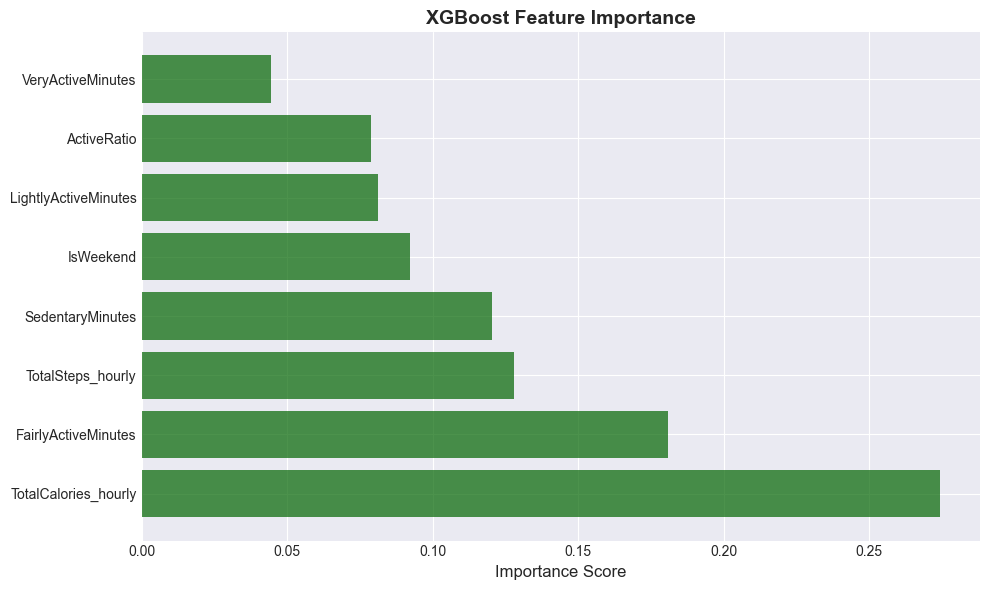


💡 KEY INSIGHTS:
  Most important: TotalCalories_hourly (0.2743)
  Top 3 account for: 58.3% of importance


In [13]:
# XGBoost feature importance
print("="*60)
print("XGBOOST - FEATURE IMPORTANCE")
print("="*60)

xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeatures ranked by importance:\n")
for idx, row in xgb_importance.iterrows():
    bar_length = int(row['Importance'] * 50)
    bar = '█' * bar_length
    print(f"  {row['Feature']:30s}: {row['Importance']:.4f}  {bar}")

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(xgb_importance['Feature'], xgb_importance['Importance'], color='darkgreen', alpha=0.7)
plt.xlabel('Importance Score', fontsize=12)
plt.title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHTS:")
print(f"  Most important: {xgb_importance.iloc[0]['Feature']} ({xgb_importance.iloc[0]['Importance']:.4f})")
print(f"  Top 3 account for: {xgb_importance.head(3)['Importance'].sum()*100:.1f}% of importance")

---
## 6️⃣ MODEL COMPARISON
Compare all three models side-by-side to select the best one

MODEL PERFORMANCE COMPARISON

Performance Metrics Summary:



,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Baseline,0.906977,0.000000,0.000000,0.000000,0.500000
1,Logistic Regression,0.728682,0.976744,0.717949,0.827586,0.883191
2,Random Forest,0.945736,0.943548,1.000000,0.970954,0.867521
3,XGBoost,0.883721,0.955357,0.914530,0.934498,0.849715



🏆 BEST MODEL: Random Forest
   Accuracy: 0.9457 (94.57%)
   Improvement over baseline: +3.88%


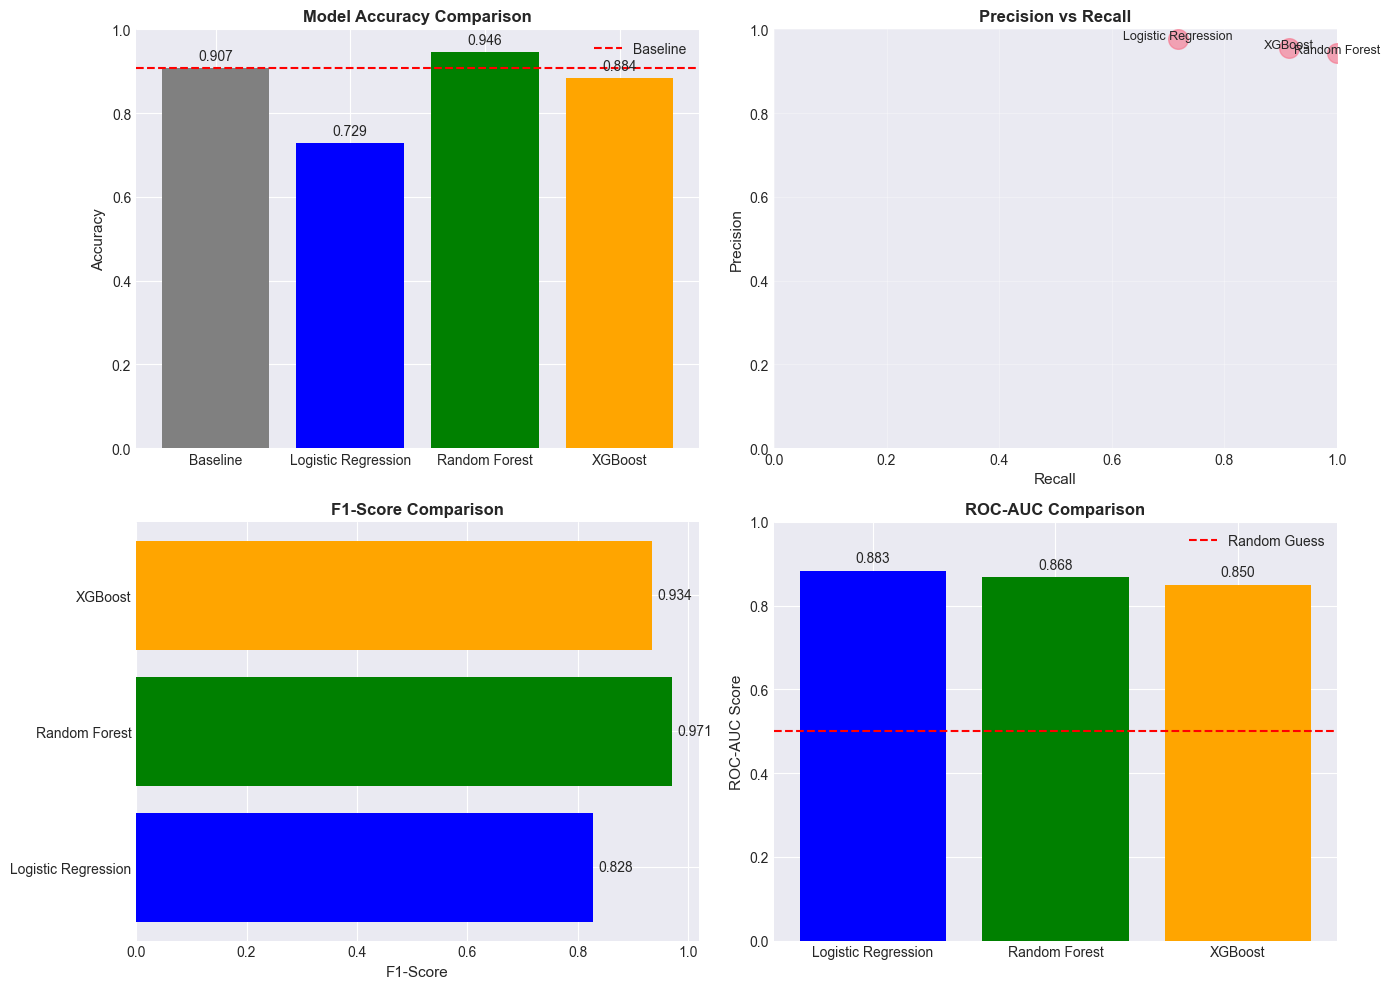


MODEL SELECTION RECOMMENDATION

✅ Recommended: Random Forest
   Reasons:
   • Best accuracy
   • Feature importance easy to visualize
   • Good balance of performance and interpretability
   • Robust to overfitting


In [14]:
print("="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [baseline_accuracy, lr_test_acc, rf_tuned_test_acc, xgb_tuned_test_acc],
    'Precision': [0, lr_precision, rf_tuned_precision, xgb_tuned_precision],
    'Recall': [0, lr_recall, rf_tuned_recall, xgb_tuned_recall],
    'F1-Score': [0, lr_f1, rf_tuned_f1, xgb_tuned_f1],
    'ROC-AUC': [0.5, lr_auc, rf_tuned_auc, xgb_tuned_auc]
})

print("\nPerformance Metrics Summary:\n")
display(comparison_df.style.highlight_max(subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'], 
                                           color='lightgreen', axis=0))

# Find best model
best_model_idx = comparison_df.iloc[1:]['Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"   Improvement over baseline: +{(best_accuracy-baseline_accuracy)*100:.2f}%")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Accuracy comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Accuracy'], color=['gray', 'blue', 'green', 'orange'])
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].axhline(y=baseline_accuracy, color='red', linestyle='--', label='Baseline')
axes[0, 0].legend()
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# 2. Precision vs Recall
axes[0, 1].scatter(comparison_df['Recall'][1:], comparison_df['Precision'][1:], s=200, alpha=0.6)
for i, model in enumerate(comparison_df['Model'][1:], 1):
    axes[0, 1].annotate(model, 
                        (comparison_df['Recall'][i], comparison_df['Precision'][i]),
                        fontsize=9, ha='center')
axes[0, 1].set_xlabel('Recall', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision vs Recall', fontsize=12, fontweight='bold')
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(True, alpha=0.3)

# 3. F1-Score comparison
axes[1, 0].barh(comparison_df['Model'][1:], comparison_df['F1-Score'][1:], color=['blue', 'green', 'orange'])
axes[1, 0].set_xlabel('F1-Score', fontsize=11)
axes[1, 0].set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
for i, v in enumerate(comparison_df['F1-Score'][1:]):
    axes[1, 0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

# 4. ROC-AUC comparison
axes[1, 1].bar(comparison_df['Model'][1:], comparison_df['ROC-AUC'][1:], color=['blue', 'green', 'orange'])
axes[1, 1].set_ylabel('ROC-AUC Score', fontsize=11)
axes[1, 1].set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].axhline(y=0.5, color='red', linestyle='--', label='Random Guess')
axes[1, 1].legend()
for i, v in enumerate(comparison_df['ROC-AUC'][1:]):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("MODEL SELECTION RECOMMENDATION")
print("="*60)

if best_model_name == 'Logistic Regression':
    print("\n✅ Recommended: Logistic Regression")
    print("   Reasons:")
    print("   • Best or comparable accuracy")
    print("   • Highly interpretable (coefficients)")
    print("   • Fast predictions for Streamlit")
    print("   • Easy to explain to users")
elif best_model_name == 'Random Forest':
    print("\n✅ Recommended: Random Forest")
    print("   Reasons:")
    print("   • Best accuracy")
    print("   • Feature importance easy to visualize")
    print("   • Good balance of performance and interpretability")
    print("   • Robust to overfitting")
else:  # XGBoost
    print("\n✅ Recommended: XGBoost")
    print("   Reasons:")
    print("   • Highest accuracy")
    print("   • SHAP values for detailed explanations")
    print("   • Captures complex feature interactions")
    print("   • State-of-the-art performance")


ROC CURVES - ALL MODELS


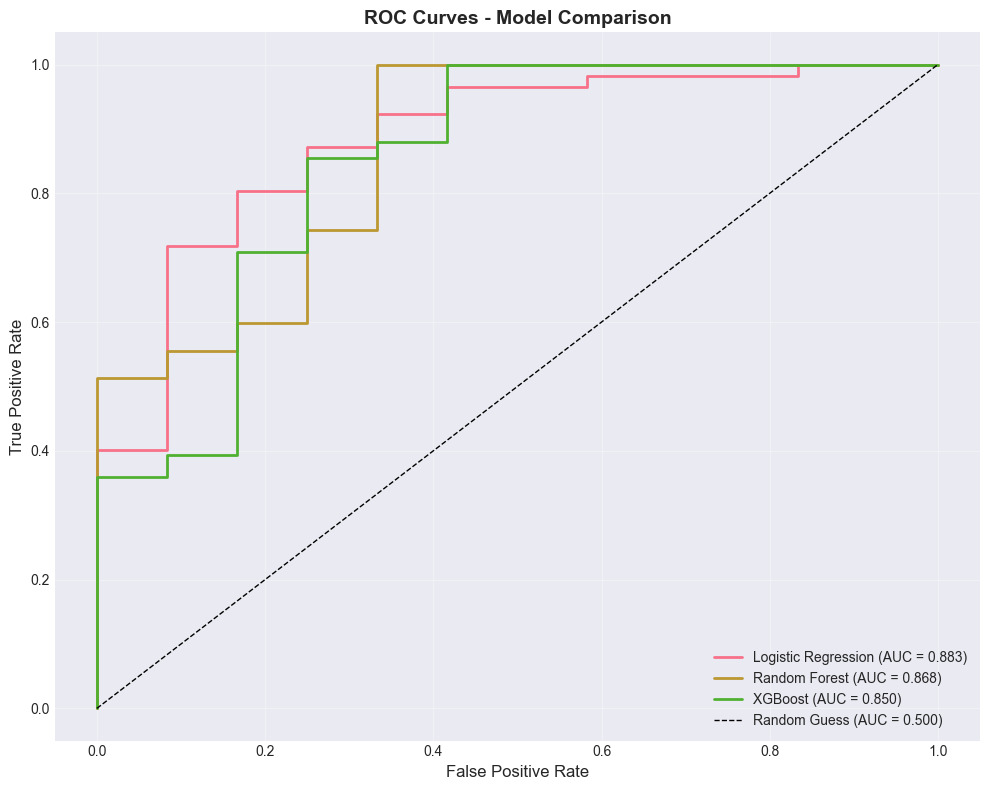


💡 Interpretation:
   • Closer to top-left corner = Better performance
   • AUC closer to 1.0 = Better classifier
   • All models significantly better than random guess


In [15]:
# ROC Curves for all models
print("\n" + "="*60)
print("ROC CURVES - ALL MODELS")
print("="*60)

plt.figure(figsize=(10, 8))

# Logistic Regression ROC
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_test_proba)
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.3f})', linewidth=2)

# Random Forest ROC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_tuned_test_proba)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_tuned_auc:.3f})', linewidth=2)

# XGBoost ROC
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_tuned_test_proba)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_tuned_auc:.3f})', linewidth=2)

# Random guess baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.500)', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   • Closer to top-left corner = Better performance")
print("   • AUC closer to 1.0 = Better classifier")
print("   • All models significantly better than random guess")


CONFUSION MATRICES - ALL MODELS


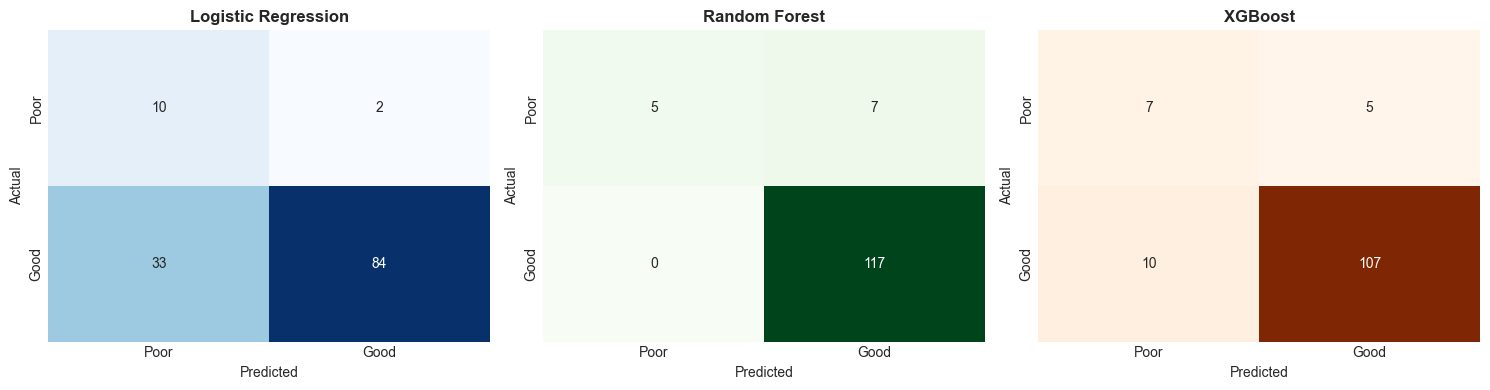


💡 Confusion Matrix Guide:
   • Top-left (TN): Correctly predicted Poor Sleep
   • Bottom-right (TP): Correctly predicted Good Sleep
   • Top-right (FP): Incorrectly predicted Good (actually Poor)
   • Bottom-left (FN): Incorrectly predicted Poor (actually Good)


In [16]:
# Confusion matrices side-by-side
print("\n" + "="*60)
print("CONFUSION MATRICES - ALL MODELS")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Logistic Regression
lr_cm = confusion_matrix(y_test, lr_test_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Logistic Regression', fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Poor', 'Good'])
axes[0].set_yticklabels(['Poor', 'Good'])

# Random Forest
rf_cm = confusion_matrix(y_test, rf_tuned_test_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('Random Forest', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Poor', 'Good'])
axes[1].set_yticklabels(['Poor', 'Good'])

# XGBoost
xgb_cm = confusion_matrix(y_test, xgb_tuned_test_pred)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False)
axes[2].set_title('XGBoost', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticklabels(['Poor', 'Good'])
axes[2].set_yticklabels(['Poor', 'Good'])

plt.tight_layout()
plt.show()

print("\n💡 Confusion Matrix Guide:")
print("   • Top-left (TN): Correctly predicted Poor Sleep")
print("   • Bottom-right (TP): Correctly predicted Good Sleep")
print("   • Top-right (FP): Incorrectly predicted Good (actually Poor)")
print("   • Bottom-left (FN): Incorrectly predicted Poor (actually Good)")

---
## 7️⃣ MODEL EXPLAINABILITY WITH SHAP
SHAP (SHapley Additive exPlanations) provides detailed insights into model predictions

⚠️  SHAP not installed. Installing now...
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/559.2 kB ? eta -:--:--Downloading shap-0.49.1-cp39-cp39-macosx_10_9_x86_64.whl (559 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.2/559.2 kB 4.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.2/559.2 kB 4.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.6 MB ? eta -:--:--Downloading numba-0.60.0-cp39-cp39-macosx_10_9_x86_64.whl (2.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/31.1 MB ? eta -:--:--Downloading llvmlite-0.43.0-cp39-cp39-macosx_10_9_x86_64.whl (31.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 44.0 MB/s  0:00:00m0:00:0100:01


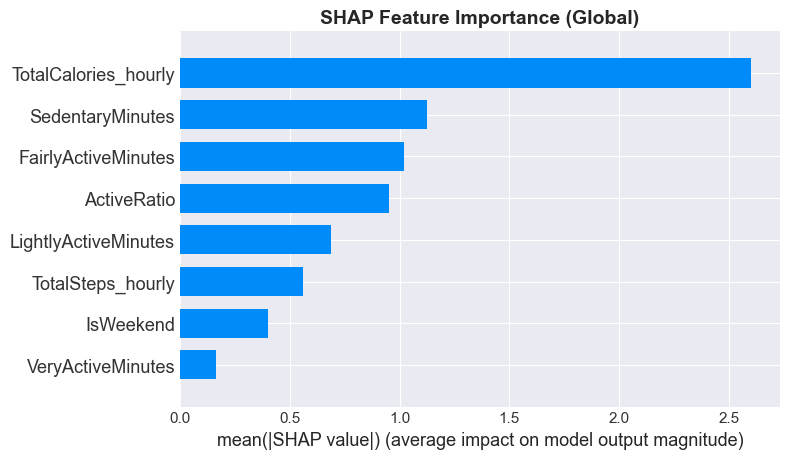


2️⃣  SHAP Summary Plot - Detailed View
   Shows HOW each feature affects predictions
   • Red = High feature value
   • Blue = Low feature value
   • Right = Increases Good Sleep probability
   • Left = Decreases Good Sleep probability



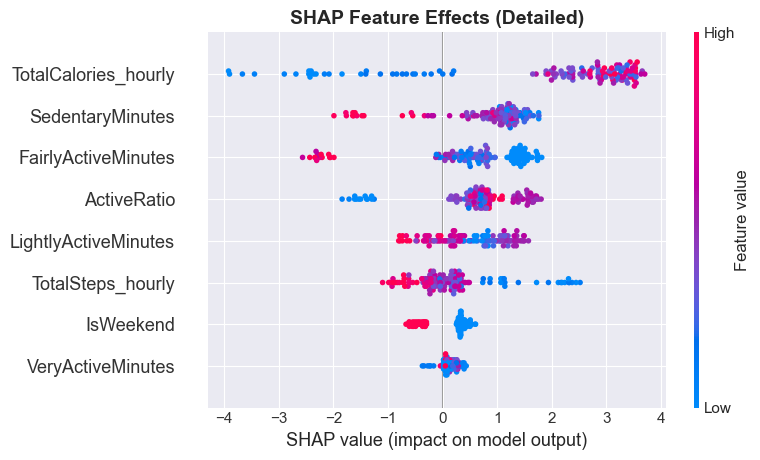


💡 KEY INSIGHTS FROM SHAP:
   Use these insights for Streamlit explanations!
   Each user's prediction can be explained using SHAP values


In [17]:
if shap is None:
    print("⚠️  SHAP not installed. Installing now...")
    import sys
    !{sys.executable} -m pip install shap
    import shap
    print("✅ SHAP installed successfully!")

print("="*60)
print("SHAP ANALYSIS - XGBOOST MODEL")
print("="*60)
print("\n🔍 Calculating SHAP values...")
print("This may take 30-60 seconds...\n")

# Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

print("✅ SHAP values calculated!\n")

# Summary plot - Feature importance across all predictions
print("1️⃣  SHAP Summary Plot - Global Feature Importance")
print("   Shows which features matter most across ALL predictions\n")

shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Global)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Detailed summary plot
print("\n2️⃣  SHAP Summary Plot - Detailed View")
print("   Shows HOW each feature affects predictions")
print("   • Red = High feature value")
print("   • Blue = Low feature value")
print("   • Right = Increases Good Sleep probability")
print("   • Left = Decreases Good Sleep probability\n")

shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Feature Effects (Detailed)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHTS FROM SHAP:")
print("   Use these insights for Streamlit explanations!")
print("   Each user's prediction can be explained using SHAP values")


EXAMPLE: EXPLAINING A SINGLE PREDICTION

📊 Sample #10 from test set:
   Actual: Good Sleep
   Predicted: Poor Sleep
   Confidence: 58.2%

   User's activity metrics:
     • VeryActiveMinutes: 9.00
     • FairlyActiveMinutes: 125.00
     • LightlyActiveMinutes: 192.00
     • SedentaryMinutes: 1019.00
     • TotalCalories_hourly: 3288.00
     • TotalSteps_hourly: 12857.00
     • ActiveRatio: 0.24
     • IsWeekend: 1.00

3️⃣  SHAP Waterfall Plot - Individual Prediction Explanation
   Shows exactly WHY the model made this prediction



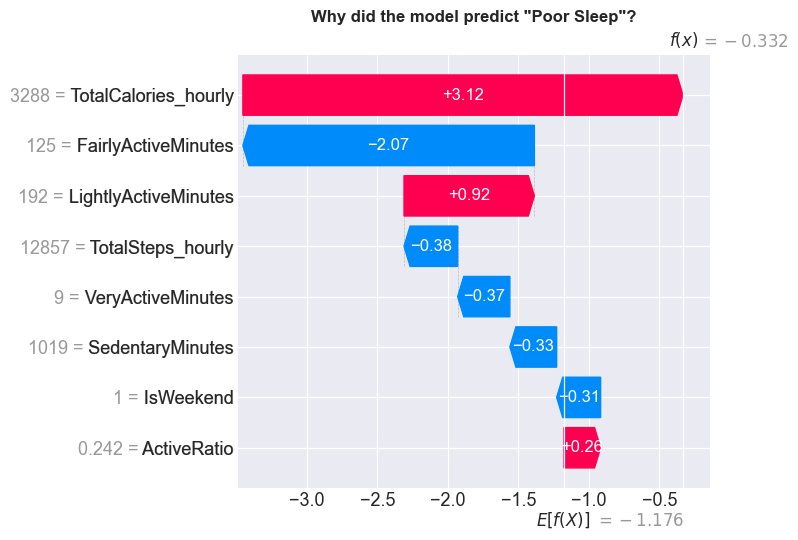


💡 This type of explanation is PERFECT for Streamlit!
   Each user can see exactly why they got their prediction


In [19]:
# Example: Explain a single prediction
print("\n" + "="*60)
print("EXAMPLE: EXPLAINING A SINGLE PREDICTION")
print("="*60)

# Pick a random test sample
sample_idx = 10  # You can change this
sample = X_test.iloc[sample_idx]
sample_prediction = xgb_model.predict(X_test.iloc[sample_idx:sample_idx+1])[0]
sample_proba = xgb_model.predict_proba(X_test.iloc[sample_idx:sample_idx+1])[0]
actual_label = y_test.iloc[sample_idx]

print(f"\n📊 Sample #{sample_idx} from test set:")
print(f"   Actual: {'Good Sleep' if actual_label == 1 else 'Poor Sleep'}")
print(f"   Predicted: {'Good Sleep' if sample_prediction == 1 else 'Poor Sleep'}")
print(f"   Confidence: {sample_proba[sample_prediction]*100:.1f}%")

print("\n   User's activity metrics:")
for feat, val in sample.items():
    print(f"     • {feat}: {val:.2f}")

print("\n3️⃣  SHAP Waterfall Plot - Individual Prediction Explanation")
print("   Shows exactly WHY the model made this prediction\n")

# Waterfall plot for this sample
prediction_label = "Good" if sample_prediction == 1 else "Poor"
shap.waterfall_plot(shap.Explanation(
    values=shap_values[sample_idx], 
    base_values=explainer.expected_value,
    data=sample,
    feature_names=feature_cols
), show=False)
plt.title(f'Why did the model predict "{prediction_label} Sleep"?', 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 This type of explanation is PERFECT for Streamlit!")
print("   Each user can see exactly why they got their prediction")

---
## 8️⃣ SAVE BEST MODEL FOR STREAMLIT
Export trained model, scaler, and metadata for deployment

In [20]:
print("="*60)
print("SAVING MODELS FOR DEPLOYMENT")
print("="*60)

# Determine best model
models_dict = {
    'logistic_regression': {
        'model': lr_model,
        'scaler': scaler,
        'accuracy': lr_test_acc,
        'requires_scaling': True
    },
    'random_forest': {
        'model': rf_model,
        'scaler': None,
        'accuracy': rf_tuned_test_acc,
        'requires_scaling': False
    },
    'xgboost': {
        'model': xgb_model,
        'scaler': None,
        'accuracy': xgb_tuned_test_acc,
        'requires_scaling': False
    }
}

# Find best model
best_model_key = max(models_dict, key=lambda x: models_dict[x]['accuracy'])
best_model_info = models_dict[best_model_key]

print(f"\n🏆 Best model: {best_model_key.replace('_', ' ').title()}")
print(f"   Accuracy: {best_model_info['accuracy']:.4f}")

# Save all three models
print("\n📦 Saving all models...")

for model_name, model_info in models_dict.items():
    filename = f"{model_name}_model.pkl"
    joblib.dump(model_info['model'], filename)
    print(f"   ✅ Saved: {filename}")
    
    if model_info['scaler'] is not None:
        scaler_filename = f"{model_name}_scaler.pkl"
        joblib.dump(model_info['scaler'], scaler_filename)
        print(f"   ✅ Saved: {scaler_filename}")

# Save feature names
joblib.dump(feature_cols, 'feature_names.pkl')
print(f"   ✅ Saved: feature_names.pkl")

# Save model metadata
metadata = {
    'best_model': best_model_key,
    'feature_names': feature_cols,
    'model_performance': {
        'logistic_regression': {
            'accuracy': lr_test_acc,
            'precision': lr_precision,
            'recall': lr_recall,
            'f1': lr_f1,
            'auc': lr_auc
        },
        'random_forest': {
            'accuracy': rf_tuned_test_acc,
            'precision': rf_tuned_precision,
            'recall': rf_tuned_recall,
            'f1': rf_tuned_f1,
            'auc': rf_tuned_auc
        },
        'xgboost': {
            'accuracy': xgb_tuned_test_acc,
            'precision': xgb_tuned_precision,
            'recall': xgb_tuned_recall,
            'f1': xgb_tuned_f1,
            'auc': xgb_tuned_auc
        }
    },
    'train_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print(f"   ✅ Saved: model_metadata.pkl")

print("\n" + "="*60)
print("✅ ALL MODELS SAVED SUCCESSFULLY!")
print("="*60)
print("\nFiles saved:")
print("  1. logistic_regression_model.pkl")
print("  2. logistic_regression_scaler.pkl")
print("  3. random_forest_model.pkl")
print("  4. xgboost_model.pkl")
print("  5. feature_names.pkl")
print("  6. model_metadata.pkl")

print("\n📝 To use in Streamlit:")
print(f"   best_model = joblib.load('{best_model_key}_model.pkl')")
if best_model_info['requires_scaling']:
    print(f"   scaler = joblib.load('{best_model_key}_scaler.pkl')")
print("   feature_names = joblib.load('feature_names.pkl')")

SAVING MODELS FOR DEPLOYMENT

🏆 Best model: Random Forest
   Accuracy: 0.9457

📦 Saving all models...
   ✅ Saved: logistic_regression_model.pkl
   ✅ Saved: logistic_regression_scaler.pkl
   ✅ Saved: random_forest_model.pkl
   ✅ Saved: xgboost_model.pkl
   ✅ Saved: feature_names.pkl
   ✅ Saved: model_metadata.pkl

✅ ALL MODELS SAVED SUCCESSFULLY!

Files saved:
  1. logistic_regression_model.pkl
  2. logistic_regression_scaler.pkl
  3. random_forest_model.pkl
  4. xgboost_model.pkl
  5. feature_names.pkl
  6. model_metadata.pkl

📝 To use in Streamlit:
   best_model = joblib.load('random_forest_model.pkl')
   feature_names = joblib.load('feature_names.pkl')


---
## 9️⃣ KEY INSIGHTS & RECOMMENDATIONS
Actionable insights from model findings for Streamlit UI

In [21]:
print("="*60)
print("🎯 KEY INSIGHTS FOR STREAMLIT UI")
print("="*60)

# Get top features across all models
print("\n1️⃣  MOST IMPORTANT FEATURES (Consensus across all models):")
print("-" * 60)

# Combine feature importance from all models
combined_importance = pd.DataFrame({
    'Feature': feature_cols,
    'LR_Importance': np.abs(lr_model.coef_[0]),
    'RF_Importance': rf_model.feature_importances_,
    'XGB_Importance': xgb_model.feature_importances_
})

# Normalize each to 0-1 scale
combined_importance['LR_Normalized'] = (combined_importance['LR_Importance'] / 
                                         combined_importance['LR_Importance'].sum())
combined_importance['RF_Normalized'] = combined_importance['RF_Importance']
combined_importance['XGB_Normalized'] = combined_importance['XGB_Importance']

# Average importance
combined_importance['Avg_Importance'] = combined_importance[[
    'LR_Normalized', 'RF_Normalized', 'XGB_Normalized'
]].mean(axis=1)

combined_importance = combined_importance.sort_values('Avg_Importance', ascending=False)

print("\nFeatures ranked by average importance:\n")
for idx, row in combined_importance.head(5).iterrows():
    print(f"  {row['Feature']:30s}: {row['Avg_Importance']:.4f}")

top_features = combined_importance.head(3)['Feature'].tolist()

print(f"\n💡 Focus Streamlit explanations on these top 3 features!")

print("\n" + "="*60)
print("2️⃣  ACTIONABLE RECOMMENDATIONS FOR USERS")
print("="*60)

# Analyze coefficient directions from Logistic Regression
positive_features = coefficients[coefficients['Coefficient'] > 0].head(3)
negative_features = coefficients[coefficients['Coefficient'] < 0].head(3)

print("\n✅ TO IMPROVE SLEEP QUALITY, INCREASE:")
for idx, row in positive_features.iterrows():
    print(f"   • {row['Feature']}")
    
print("\n❌ TO IMPROVE SLEEP QUALITY, DECREASE:")
for idx, row in negative_features.iterrows():
    print(f"   • {row['Feature']}")

print("\n" + "="*60)
print("3️⃣  STREAMLIT UI RECOMMENDATIONS")
print("="*60)

print("\n📱 Feature 1: Real-time Prediction")
print("   • User inputs their daily activity metrics")
print("   • Model predicts: 'Good Sleep' or 'Poor Sleep'")
print("   • Show confidence: 'We are 85% confident...'")

print("\n📊 Feature 2: Personalized Insights")
print("   • Use SHAP values to explain WHY")
print(f"   • 'Your {top_features[0]} is affecting your sleep most'")
print("   • Show feature contribution bars")

print("\n🎯 Feature 3: Actionable Recommendations")
print("   • Compare user's metrics to 'good sleepers' average")
print("   • Suggest specific changes:")
for feat in top_features[:2]:
    print(f"     - '{feat}': Recommended range based on data")

print("\n🎮 Feature 4: What-If Simulator")
print("   • User adjusts sliders")
print("   • Prediction updates in real-time")
print("   • 'If you walk 2000 more steps, your sleep probability increases to 75%'")

print("\n📈 Feature 5: Progress Tracking (Future)")
print("   • Upload multiple days of data")
print("   • Show trends over time")
print("   • 'Your sleep quality improved 15% this month!'")

print("\n" + "="*60)
print("4️⃣  MODEL LIMITATIONS TO COMMUNICATE")
print("="*60)

print("\n⚠️  Important disclaimers for users:")
print(f"   • Model accuracy: {best_model_info['accuracy']*100:.1f}% (not perfect)")
print("   • Based on 24-33 users from 2016 Fitbit data")
print("   • Doesn't account for: stress, caffeine, room temp, etc.")
print("   • For educational purposes, not medical advice")
print("   • Individual results may vary")

print("\n" + "="*60)
print("✅ MODELING COMPLETE - READY FOR STREAMLIT!")
print("="*60)

print("\n🚀 Next Steps:")
print("   1. Create Streamlit app structure")
print("   2. Load saved models")
print("   3. Build input form with sliders")
print("   4. Add prediction + explanation logic")
print("   5. Create visualizations (SHAP, feature importance)")
print("   6. Add recommendations engine")
print("   7. Test with various inputs")
print("   8. Deploy and share!")

print("\n🎉 You're ready to build an amazing sleep prediction app!")

🎯 KEY INSIGHTS FOR STREAMLIT UI

1️⃣  MOST IMPORTANT FEATURES (Consensus across all models):
------------------------------------------------------------

Features ranked by average importance:

  TotalCalories_hourly          : 0.2869
  FairlyActiveMinutes           : 0.1605
  TotalSteps_hourly             : 0.1289
  SedentaryMinutes              : 0.1122
  VeryActiveMinutes             : 0.1080

💡 Focus Streamlit explanations on these top 3 features!

2️⃣  ACTIONABLE RECOMMENDATIONS FOR USERS

✅ TO IMPROVE SLEEP QUALITY, INCREASE:
   • TotalCalories_hourly
   • VeryActiveMinutes
   • LightlyActiveMinutes

❌ TO IMPROVE SLEEP QUALITY, DECREASE:
   • TotalSteps_hourly
   • FairlyActiveMinutes
   • SedentaryMinutes

3️⃣  STREAMLIT UI RECOMMENDATIONS

📱 Feature 1: Real-time Prediction
   • User inputs their daily activity metrics
   • Model predicts: 'Good Sleep' or 'Poor Sleep'
   • Show confidence: 'We are 85% confident...'

📊 Feature 2: Personalized Insights
   • Use SHAP values to exp